In [1]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import Row
import matplotlib.pyplot as plt


## K-means minibatch implementation

In [2]:
# build a SparkSession 
#   connect to the master node on the port where the master node is listening (7077)
#   declare the app name 
#   configure the executor memory to 512 MB
#   either *connect* or *create* a new Spark Context
spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("My first spark application")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/27 15:49:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

## load the dataset

In [4]:
#CREATE A TOY DATASET FOR TESTING

# Parameters for toy dataset
num_points_per_cluster = 5
num_clusters = 3
dim = 2  # 2D points for easy visualization
spread = 0.5
seed = 42
np.random.seed(seed)

# Generate toy points
data = []
for cluster_id in range(num_clusters):
    # Generate points around a cluster center
    center = np.random.uniform(-5, 5, size=dim)
    points = center + spread * np.random.randn(num_points_per_cluster, dim)
    for point in points:
        # Create a Row with each feature as a separate column
        row_dict = {f"f{i}": float(point[i]) for i in range(dim)}
        row_dict["label"] = int(cluster_id)
        data.append(Row(**row_dict))

# Convert to Spark DataFrame
df = spark.createDataFrame(data)
df.show(truncate=False)


+--------------------+--------------------+-----+
|f0                  |f1                  |label|
+--------------------+--------------------+-----+
|-0.9307545424760288 |5.268657992303173   |0    |
|-1.371675498888043  |4.39007458562457    |0    |
|-0.46499240377267936|4.890860428675615   |0    |
|-1.489336004493851  |4.778423085892143   |0    |
|-1.4863076579326062 |4.2742781873140325  |0    |
|-2.820036486661139  |-0.03357944829810772|1    |
|-2.4639931305718346 |0.4046879826200156  |1    |
|-2.411589608165228  |-0.4585875343452671 |1    |
|-1.2247531859438459 |0.13467616607911082 |1    |
|-1.923813468060661  |-0.46480977678434976|1    |
|0.3486488999092735  |-4.347646863627187  |2    |
|0.6238263436610224  |-4.681342747696661  |2    |
|0.6232923825057264  |-3.6093567805455535 |2    |
|0.9173970762514579  |-5.064351337277973  |2    |
|1.3354181446720195  |-5.145917697785533  |2    |
+--------------------+--------------------+-----+



## Algorithm implementation

In [5]:
sc = spark.sparkContext

In [6]:
# Initialize centroids and other quantities:
K = 3
num__iterations = 1000
fraction_dataframe = 0.1

# main loop

In [7]:
def cluster_assignment_partition(rows,broadcasted_centroids,feature_cols_bc):
    """
    Function to assign a data point in a cluster when dealing with a distributed system, 
    based on the distance to the closest centroid (K-means).
    """
    centroids = broadcasted_centroids.value
    feature_cols = feature_cols_bc.value
    results = []
    for row in rows:
        point = np.array([row[c] for c in feature_cols], dtype=float)
        distances = [np.linalg.norm(point - c) for c in centroids]
        cluster_id = np.argmin(distances)
        results.append((cluster_id, (point, 1)))
    return results


In [ ]:
def minibatch_Kmeans(df, K, num__iterations, batch_fraction, seed=345, has_label = True, persist = True):
    """
    Minibatch K-means main loop

    - df: spark dataframe
    - K: number of clusters
    - num_iterations: number of iterations to run the algorithm
    - batch_fraction: fraction of data sampled from the original dataframe that constitutes a minibacth
    - seed: random seed to sample the centroids
    - has_label: Boolean variable to clean the dataset if it has the label column
    - persist: Boolean variable that activates the "persist" operation of the dataframe if True
    """
    # extract feature columns and remove labels (if present)
    feature_cols = [c for c in df.columns if c != 'label']   # or filter by a pattern if needed
    if has_label:
        features_only_df = df.select(*feature_cols)
    else:
        features_only_df = df

    # initialize centroids by picking randomly some points in the dataframe
    centroids = features_only_df.rdd.takeSample(withReplacement=False, num=K, seed=seed)
    centroids = np.array([np.array(row) for row in centroids])
    
    # broadcast feature columns so they can be read by the partitions (they are sent to them only once)
    feature_cols_bc = sc.broadcast(feature_cols)  
    dim = centroids.shape[1]

    # counter arry to update the learning rates
    counter = np.zeros(shape=K)

    if persist:
        # Persist the dataframe: we do this because we need to access it every iteration to sample the minibatch (at the end we will unpersist)
        features_only_df.persist()
        
    for i in range(num__iterations):
        print('iteration number:', i+1)
        # sample the minibatch
        minibatch = features_only_df.rdd.sample(withReplacement=False, fraction = batch_fraction)
        
        # broadcast centroids 
        broadcasted_centroids = sc.broadcast(centroids)

        # map procedure - assign the points of the minibatch to the clusters using the function cluster_assignment_partition (cluster_id,(coordinates,1))
        partial_assignments = minibatch.mapPartitions(lambda it:cluster_assignment_partition(it,broadcasted_centroids,feature_cols_bc))

        # reduce step - reduce by key to count the points for cluster. Single entry: (cluster_id,(coordinates,number_of_points_per_cluster))
        counter_points = partial_assignments.reduceByKey(lambda a,b: (a[0] + b[0], a[1] + b[1]) ).collect()

        
        # per-iteration arrays - count the number of points for each cluster_id and take the sum of all the coordinates for a single cluster
        # (we need them to make an average at the end)

        current_counts = np.zeros(K)
        coordinates = np.zeros((K, dim))
        
        # fill them from Spark result
        for cluster_id, (sum_coords, count_iter) in counter_points:
            current_counts[cluster_id] = count_iter
            coordinates[cluster_id] = sum_coords

        # update global counters and centroids
        for k in range(K):
            if current_counts[k] > 0:  # cluster got points this batch
                counter[k] += current_counts[k]  # cumulative count
                eta = 1.0 / counter[k]           # learning rate
                mean_coords = coordinates[k] / current_counts[k]
                centroids[k] = (1 - eta) * centroids[k] + eta * mean_coords # exponential average of each centroid
        
        # at the end of every iteration, remove the broadcasted variables
        broadcasted_centroids.destroy()

    # Peform the final point assignment:
    # broadcast centroids (as before)
    broadcasted_centroids = sc.broadcast(centroids)
    
    # final assignment:
    final_assignments_rdd = features_only_df.rdd.mapPartitions(lambda it: cluster_assignment_partition(it, broadcasted_centroids, feature_cols_bc)) \
                              .map(lambda x: (x[1][0].tolist(), int(x[0])))  # convert array to list and cluster_id to int

    # wrap all in a Spark dataframe to avoid calling collect 
    final_assignments_df = final_assignments_rdd.toDF(["features", "cluster_id"])

    if persist:
        # unpersist the dataframe to free memory
        features_only_df.unpersist()
        
    
    return final_assignments_df,centroids 


## Evaluation

In [9]:
final_assignment_df, centroids = minibatch_Kmeans(df, 3, num__iterations = 200, batch_fraction = 0.1, seed=42)

iteration number: 1


iteration number: 2
iteration number: 3
iteration number: 4
iteration number: 5
iteration number: 6
iteration number: 7
iteration number: 8
iteration number: 9
iteration number: 10
iteration number: 11
iteration number: 12
iteration number: 13
iteration number: 14
iteration number: 15
iteration number: 16
iteration number: 17
iteration number: 18
iteration number: 19
iteration number: 20
iteration number: 21
iteration number: 22
iteration number: 23
iteration number: 24
iteration number: 25
iteration number: 26
iteration number: 27
iteration number: 28
iteration number: 29
iteration number: 30
iteration number: 31


iteration number: 32
iteration number: 33
iteration number: 34
iteration number: 35
iteration number: 36
iteration number: 37
iteration number: 38
iteration number: 39
iteration number: 40
iteration number: 41
iteration number: 42
iteration number: 43
iteration number: 44
iteration number: 45
iteration number: 46
iteration number: 47
iteration number: 48
iteration number: 49
iteration number: 50
iteration number: 51
iteration number: 52
iteration number: 53
iteration number: 54
iteration number: 55
iteration number: 56
iteration number: 57
iteration number: 58
iteration number: 59
iteration number: 60
iteration number: 61
iteration number: 62
iteration number: 63
iteration number: 64
iteration number: 65
iteration number: 66
iteration number: 67
iteration number: 68
iteration number: 69
iteration number: 70
iteration number: 71
iteration number: 72
iteration number: 73
iteration number: 74
iteration number: 75
iteration number: 76
iteration number: 77
iteration number: 78
iteration num

iteration number: 172
iteration number: 173
iteration number: 174
iteration number: 175
iteration number: 176
iteration number: 177
iteration number: 178
iteration number: 179
iteration number: 180
iteration number: 181
iteration number: 182
iteration number: 183
iteration number: 184
iteration number: 185
iteration number: 186
iteration number: 187
iteration number: 188
iteration number: 189
iteration number: 190
iteration number: 191
iteration number: 192
iteration number: 193
iteration number: 194
iteration number: 195
iteration number: 196
iteration number: 197
iteration number: 198
iteration number: 199
iteration number: 200


## Visual check for correctness

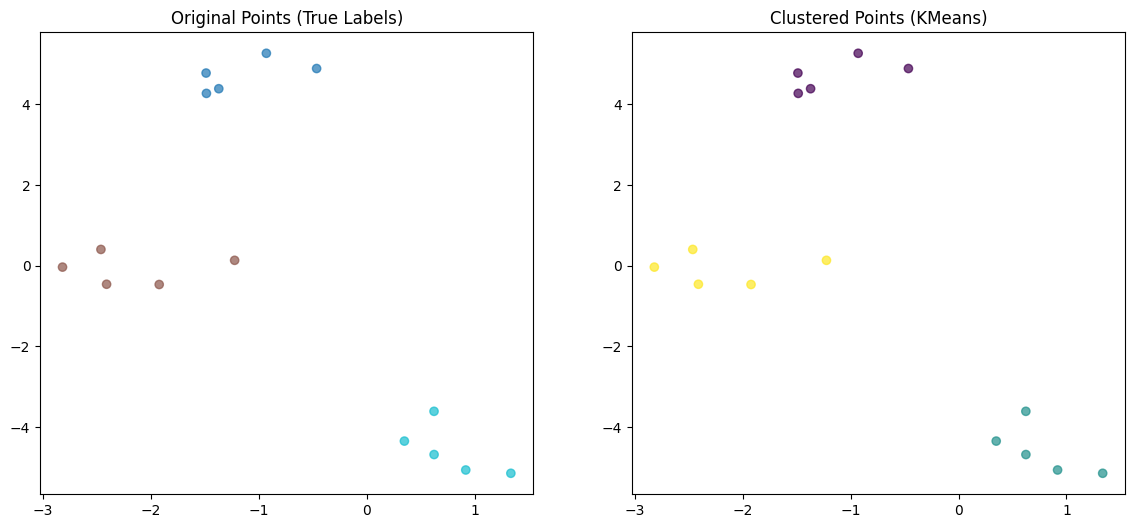

In [10]:
# Columns with features
feature_cols = [c for c in df.columns if c != 'label']

# Original points as numpy array
original_points = np.array(df.select(*feature_cols).collect())
true_labels = np.array(df.select("label").rdd.map(lambda r: r[0]).collect())

# Clustered points as numpy array
clustered_points = np.array(final_assignment_df.select("features").rdd.map(lambda r: r[0]).collect())
cluster_ids = np.array(final_assignment_df.select("cluster_id").rdd.map(lambda r: r[0]).collect())

original_points_2d = original_points
clustered_points_2d = clustered_points

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original points colored by true label
scatter1 = axes[0].scatter(original_points_2d[:, 0], original_points_2d[:, 1], c=true_labels, cmap='tab10', alpha=0.7)
axes[0].set_title("Original Points (True Labels)")

# Clustered points colored by cluster assignment
scatter2 = axes[1].scatter(clustered_points_2d[:, 0], clustered_points_2d[:, 1], c=cluster_ids, cmap='viridis', alpha=0.7)
axes[1].set_title("Clustered Points (KMeans)")

plt.show()


In [11]:
final_assignment_df.show()

+--------------------+----------+
|            features|cluster_id|
+--------------------+----------+
|[-0.9307545424760...|         0|
|[-1.3716754988880...|         0|
|[-0.4649924037726...|         0|
|[-1.4893360044938...|         0|
|[-1.4863076579326...|         0|
|[-2.8200364866611...|         2|
|[-2.4639931305718...|         2|
|[-2.4115896081652...|         2|
|[-1.2247531859438...|         2|
|[-1.9238134680606...|         2|
|[0.34864889990927...|         1|
|[0.62382634366102...|         1|
|[0.62329238250572...|         1|
|[0.91739707625145...|         1|
|[1.33541814467201...|         1|
+--------------------+----------+

